# Airbnb Reviews Sentiment Polarity

The objective of this project is to find out the sentiment polarities, positive or negative of the Airbnb reviews.

In my proposal, I mentioned want to do the sentiment analysis using aspect-based analysis, however, because of the speciality of this dataset as I will mention in the report, I decided to only using models to predict the sentiment polarity of each reviews.

Ok, let's begain.

In [16]:
#Import useful packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib.style.use('ggplot')
%matplotlib inline

# Load Data & Overview

In [43]:
# Load csv
listings_data = pd.read_csv('data/listings.csv', header = 0)
reviews_data = pd.read_csv('data/reviews.csv', header = 0)

False


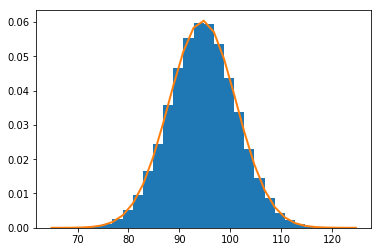

In [44]:
# The Gaussian distribution of Airbnb homes' overall ratings

list_of_col1 = ['id', 'property_type', 'reviews_per_month', 'accommodates', 'review_scores_rating']
listings_data = listings_data[list_of_col1].dropna()
mu = np.mean(listings_data.review_scores_rating.values)
sigma = np.std(listings_data.review_scores_rating.values)

s = np.random.normal(mu, sigma, 100000)

# Verify
print(abs(sigma - np.std(s, ddof=1)) < 0.01)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)), linewidth=2)
plt.show()

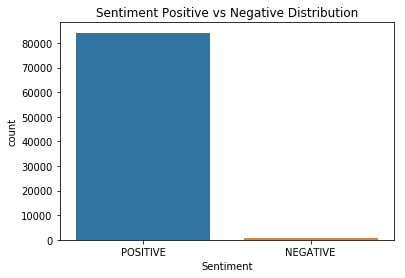

In [46]:
listings_data.loc[listings_data.review_scores_rating>=80,'Sentiment']="POSITIVE"
listings_data.loc[listings_data.review_scores_rating<80,'Sentiment']="NEGATIVE"

# Merge two datasets
listings_and_reviews = pd.merge(reviews_data, listings_data, left_on = "listing_id", right_on = "id")

list_of_col1 = ['listing_id', 'comments', 'Sentiment', 'date']
all_comments = listings_and_reviews[list_of_col1].dropna()

ax = plt.axes()
sns.countplot(all_comments.Sentiment,ax=ax)
ax.set_title('Sentiment Positive vs Negative Distribution')
plt.show()

In [47]:
data = all_comments
print("Number of positive reviews:", len(data[data.Sentiment=="POSITIVE"]))
print("Proportion of positive reviews:", len(data[data.Sentiment=="POSITIVE"])/len(data))
print("Number of negative reviews:", len(data[data.Sentiment=="NEGATIVE"]))
print("Proportion of negative reviews:", len(data[data.Sentiment=="NEGATIVE"])/len(data))

Number of positive reviews: 84202
Proportion of positive reviews: 0.9928193276815508
Number of negative reviews: 609
Proportion of negative reviews: 0.007180672318449257


This is really impressive that the proportion of Low-rated Airbnb reviews is so small. Seems like the customers were compliment with almost all the homes offered by Airbnb.

However, this might make my project very difficult in finding sufficient negative review data. So, next step I decided to specify my sample conditions first and then see some simple statistics.

## Combine and select datasets

This part, I combined "homes" table with "reviews" table using the "listing_id" as the key. And I have some principles to finalize the dataset used in this project:

1. use reviews data start from 2015-01-01 to guarantee the compatibility to current society;
2. focus on the "Apartment" type of Airbnbs;
3. focus on the Airbnbs homes that can accommodates 4 customers;
4. the reviews received per month should no less than 2 to guarantee the value of the reviews.

The reason is that this project is only aim to show a demo of the use of prediction models in dealing with sentiment analysis. Also, because of the time limitation, I decided to reduce the inintial dataset to make sure codes here won't cost too long time when running.

In [49]:
# use reviews data start from 2015-01-01
reviews_data.date = pd.to_datetime(reviews_data.date)
reviews_data = reviews_data[reviews_data.date > "2014-12-31"]

# Select homes than is "Apartment" and can accommodates 4 customers,
# and meanwhile reviews received per month should no less than 2
listings_data = listings_data[listings_data.property_type == 'Apartment'][listings_data.reviews_per_month>=2][listings_data.accommodates == 4]

list_of_col2 = ['id', 'review_scores_rating', 'Sentiment']
home_score = listings_data[list_of_col2]

# merge "homes" table with "reviews" table and select useful columns
homes_and_reviews = pd.merge(reviews_data, listings_data, left_on = "listing_id", right_on = "id")

# Here, we have our first draft experiment data to be used to train model
list_of_col3 = ['listing_id', 'comments', 'Sentiment']
home_comments = homes_and_reviews[list_of_col3].dropna()

# Take a subset of the dataset that filters out the reviews with automated postings.
auto = 'The host canceled this reservation | days before arrival | This is an automated posting'
home_comments = home_comments[home_comments.comments.str.contains(auto) == False]

# See the number of reviews that are positive or negative respectively.
home_comments.groupby('Sentiment').size()

Sentiment
NEGATIVE      41
POSITIVE    3923
dtype: int64

However, I'm afraid that only 41 negative reviews will affect the sentiment analysis model in predicting negative comments. So I'd like to add some older comments that were before 2015-01-01 to make some compensate.

Also, because if using 4000+ reviews, the processing speed is too slow, I will randomly select 1000 positive reviews and compensate negetive reviews to 500 to make sure this demo could run successfully.

In [62]:
pos_sample = home_comments[home_comments.Sentiment == "POSITIVE"].sample(1000)
neg_sample = all_comments[all_comments.Sentiment == "NEGATIVE"].sample(500).drop('date',axis=1)
all_samples = pos_sample.append(neg_sample)

# The Lexicon Approach --- NLTK Text-Processing API

The backend logic of Lexicon Approach type methods for sentiment analysis is to look at each word individually, attribute positive points for positive words and negative points for negative words, and then total the points. 

The text-processing prediction api I used here is an NLTK 2.0.4 powered text classification process. The english sentiment in nltk uses classifiers trained on both twitter sentiment as well as movie reviews. Considering that the Airbnb reviews dataset has many similar characteristics with thoes, I assumed that the results from this api should be reasonable. So, I implemented this and computed the accuracy of prediction.

Basically, the syntax is run the terminal command 'curl -d "text =review" http://text-processing.com/api/sentiment/', then it will return the predited results of the review in the following Json format:

{
    "probability":
        {
            "neg": 0.30135019761690551,
            "neutral": 0.27119050546800266,
            "pos": 0.69864980238309449
        },
    "label": "pos"
}

- Label:	will be either pos if the text is determined to be positive, neg if the text is negative, or neutral if the text is neither pos nor neg.

- Probability:	an object that contains the probability for each label. neg and pos will add up to 1, while neutral is standalone. If neutral is greater than 0.5 then the label will be neutral. Otherwise, the label will be pos or neg, whichever has the greater probability.

Besides, because this function already have its embeded training set, so the accuracy here will be only get the prediction results of all data in "home_comments" and then compare it with the original sentiment label.

In [78]:
# Use an avaliable text-processing api to get the sentiment of all reviews
import os
import json

# Functions to get the API predicted results
def getLabel(text):
    cmd = 'curl -d "text=' + text + '" http://text-processing.com/api/sentiment/'
    print(cmd)
    res = os.popen(cmd).read()
    return json.loads(res)['label']

# function to assign labels dataframe.
def predLabels(df):
    labels = []
    i = 0
    for str in df.comments:
        labels.append(getLabel(str))
        i += 1
        if i % 100 == 0:
            print(i)
#     df.label = labels
    return labels


# Here it tooks about 15 minites to finish. Please be patient if you replicate this experiment.
predicted_labels = predLabels(all_samples)

curl -d "text=This was our first AirBNB experience, and I thought it was perfect for our trip. I didn't actually get to meet Carlos, but we were able to get into the building & apartment easily.  The apartment was very clean & accurately described.  It was a perfect location for us - inbetween the Pike Market Place (about 10 minute walk) and the Space Needle (about 5 minute walk), and close to many restaurants, bars, and a grocery store.  The Belltown Area is nice - we did hear from a few locals that you need to be careful around some blocks at night, but we felt safe the entire time.  We really appreciated Carlos' flexibility with allowing us to check-out late given our later flight time.  Overall, we were very pleased." http://text-processing.com/api/sentiment/


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [388]:
orininal_labels = np.array([1 if s=="POSITIVE" else 0 for s in all_samples.Sentiment.values])

predicted_labels = np.array([1 if s=="pos" else 0 for s in all_samples.Sentiment.values])

from sklearn.metrics import accuracy_score

# Print the accuracy of using Lexicon Approach
print(accuracy_score(orininal_labels, predicted_labels))

array([1, 1, 1, ..., 1, 1, 1])

The accuracy is %.

# Recurrent Neural Network

Former kind of model apporach ignores the sequence of the words, which can lead to the loss of important information. So, I will try the RNN model in this part to see whether there are differences when doing prediction.

Referenced to https://github.com/yanndupis/RNN-Amazon-Fine-Food-Reviews/blob/master/

### Simply Processing review text

In [63]:
from string import punctuation
reviews_cleaned = []
reviews = all_samples.comments.values
for i in range(len(reviews)):
    reviews_cleaned.append(''.join([c.lower() for c in reviews if c not in punctuation]))

In [64]:
# Store all the text from each review together
text = ' '.join(reviews_cleaned)

# List all the vocabulary contained in the all reviews
vocabulary = set(text.split(' '))

# Map each word to an integer
vocabulary_to_int = {word:i for i,word in enumerate(vocabulary,0)}

def reviews_to_intArray(reviews):
    reviews_to_int = []
    for i in range(len(reviews)):
        to_int = [vocabulary_to_int[word] for word in reviews[i].split()]
        reviews_to_int.append(to_int)
    return reviews_to_int

# This takes around minites
reviews_to_int = reviews_to_intArray(reviews_cleaned)

KeyError: 'depart.'

In [ ]:
reviews_cleaned

### Training RNN

To train the RRN on the review dataset we need to determine the max_length of the array to store the integer array that representing each review and enough rows to fit one review per row. 

If the number of words in the review is less than the max_length, we can pad the list with extra zeros. If the number of words in the review are more than the max_length then I choose to limit the review to the first n words.

Here I choose max_length = 200.

In [ ]:
review_lengths = [len(review) for review in reviews_to_int]
print("Shortest review:", min(review_lengths))
print("Longest revies:",max(review_lengths))

ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

In [ ]:
pd.DataFrame(review_lengths).describe()

The mean and the third quartile of the review length is equal to 79 and 97, respectively. Therefore if we limit the review length to 200 words, we shouldn't lose too much information.

In [ ]:
max_length = 200
features = np.zeros(shape=(len(reviews_to_int),max_length),dtype=int)

for i in range(len(reviews_to_int)):
    nb_words = len(reviews_to_int[i])
    features[i] = [0]*(max_length -nb_words) + reviews_to_int[i][:200]

### Split to training and validation set

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=5435)

splitter = sss.split(features, labels)
train_index, validation_index = next(splitter)
test_index = validation_index[:int(len(validation_index)/2)]
validation_index = validation_index[int(len(validation_index)/2):]

train_x, train_y = features[train_index], labels[train_index]
val_x, val_y = features[test_index], labels[test_index]
test_x, test_y = features[validation_index], labels[validation_index]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

### Build the LSTM model with Tensorflow
The next step is to build the recurrent neural network using the popular deep learning framework, Tensorflow.

To feed input, labels and keep_prob data into Tensorflow we need to first create placeholders.
```python
inputs_ = tf.placeholder(tf.int32,[None, None],name='inputs_')
labels_ = tf.placeholder(tf.int32,[None, None],name='labels_')
keep_prob = tf.placeholder(tf.float32,name='keep_prob')
```

Once we send the input data (the reviews) to Tensorflow, we want to transform each integer representing a word into a vector. As mentioned earlier, this method is called embedding.

```python
embedding = tf.Variable(tf.random_normal((n_words,embed_size),-1,1),name='embedding_')
embed = tf.nn.embedding_lookup(embedding,inputs_)
```

Then we need to create our LSTM cells and specify the number of hidden units in the LSTM cell.
```python
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
```

It's always a good practice to add a Dropout layer to prevent the model from overfitting on the training set.
```python
drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)
```
By using tf.contrib.rnn.MultiRNNCell we can stack multiple LSTM layers. Usually in deep learning, the more hidden layers you have, the better the prediction will be.
```python
cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layer*)
```

We initialize all the states to zero.
```python
initial_state = cell.zero_state(batch_size, tf.float32)
```

Then we want to pass the input data through the LSTM cells. The output of each LSTM cell is carried to the next LSTM cell. This mechanism allow the recurrent neural network to memorize information.
```python
outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
```

To get our prediction, we use a fully connected layer with a sigmoid function.
```python
predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1,
                                                activation_fn=tf.sigmoid,
                                                weights_initializer=
                                                tf.truncated_normal_initializer(stddev=0.1))
```

To measure the accuracy of our neural network, we need to define the cost function. For this problem, we will use the mean squared error.
```python
cost = tf.losses.mean_squared_error(labels_, predictions)
```
Finally, we want to minimize our cost function in order to make our network output as close as possible to the target values. For this project, we will use the Adam optimizer.
```python
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
```

In [ ]:
lstm_size = 256
lstm_layers = 1
batch_size = 500
learning_rate = 0.001
embed_size = 200 

In [39]:
def build_rnn(vocabulary_to_int,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers):
    
    tf.reset_default_graph()
    
    n_words = len(vocabulary_to_int)
    
    with tf.name_scope('inputs'):
        inputs_ = tf.placeholder(tf.int32,[None, None],name='inputs_')
    with tf.name_scope('labels'):
        labels_ = tf.placeholder(tf.int32,[None, None],name='labels_')
    with tf.name_scope('keep_prob'):    
        keep_prob = tf.placeholder(tf.float32,name='keep_prob')
        
    with tf.name_scope('embedding'):
        embedding = tf.Variable(tf.random_normal((n_words,embed_size),-1,1),name='embedding_')
        embed = tf.nn.embedding_lookup(embedding,inputs_)
        
    with tf.name_scope("RNN_cells"):
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)

        # Stack up multiple LSTM layers, for deep learning
        cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)
        
        with tf.name_scope("RNN_init_state"):
            # Getting an initial state of all zeros
            initial_state = cell.zero_state(batch_size, tf.float32)
    
    with tf.name_scope("RNN_forward"):
        outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
        
    with tf.name_scope('predictions'):
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, 
                                                        activation_fn=tf.sigmoid,
                                                        weights_initializer=
                                                        tf.truncated_normal_initializer(stddev=0.1))   
    with tf.name_scope('cost'):
        cost = tf.losses.mean_squared_error(labels_, predictions)
        tf.summary.scalar('cost', cost)
    
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('accuracy'):
        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    merged = tf.summary.merge_all()
    
    # Export the nodes 
    export_nodes = ['inputs_', 'labels_','initial_state', 'final_state',
                    'keep_prob', 'cell', 'cost', 'predictions', 'optimizer',
                    'accuracy','merged']
    
    Graph = namedtuple('Graph', export_nodes)
    
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

To train our model, we use the stochastic gradient descent approach. This method consists of calculating an estimate of the cost function on small batches of the dataset. This approach is more scalable than a traditional gradient descent.

In [ ]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

epochs = 5

def train(model, epoch,train_writer,test_writer):
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        iteration = 1
        for e in range(epochs):
            state = sess.run(model.initial_state)

            for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
                feed = {model.inputs_: x,
                        model.labels_: y[:, None],
                        model.keep_prob: 0.5,
                        model.initial_state: state}
                summary,loss, state, _ = sess.run([model.merged,model.cost, 
                                                   model.final_state, 
                                                   model.optimizer], feed_dict=feed)

                if iteration%5==0:
                    print("Epoch: {}/{}".format(e, epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))

                train_writer.add_summary(summary, iteration)

                if iteration%25==0:
                    val_acc = []
                    val_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
                    for x, y in get_batches(val_x, val_y, batch_size):
                        feed = {model.inputs_: x,
                                model.labels_: y[:, None],
                                model.keep_prob: 1,
                                model.initial_state: val_state}
                        summary, batch_acc, val_state = sess.run([model.merged,model.accuracy, 
                                                         model.final_state], feed_dict=feed)
                        val_acc.append(batch_acc)

                    test_writer.add_summary(summary,iteration)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1
        saver.save(sess, "output/checkpoints/sentiment.ckpt")